In [1]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tree_depth = 7
trees_in_forest = 1000

train_set = pd.read_csv('Data/train.csv')
test_set = pd.read_csv('Data/test.csv')

train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


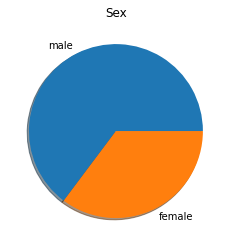

In [3]:
sex_stat = train_set.Sex.value_counts()
sex_labels = sex_stat.index
plt.pie(sex_stat, labels = sex_labels, shadow=True)
plt.title('Sex')
plt.show()

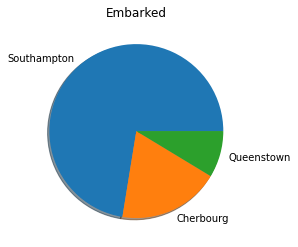

In [4]:
embarked_stat = train_set.Embarked.value_counts()
embarked_labels = ['Southampton', 'Cherbourg', 'Queenstown']
plt.pie(embarked_stat, labels = embarked_labels, shadow=True)
plt.title('Embarked')
plt.show()

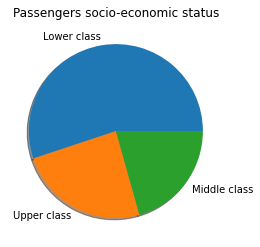

In [5]:
pclass_stat = train_set.Pclass.value_counts()
pclass_labels = ['Lower class', 'Upper class', 'Middle class']
plt.pie(pclass_stat, labels = pclass_labels, shadow=True)
plt.title('Passengers socio-economic status')
plt.show()

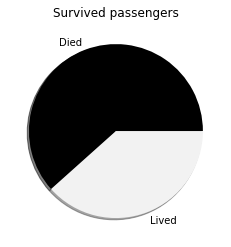

In [6]:
survived_stat = train_set.Survived.value_counts()
survived_labels = ['Died', 'Lived']
survived_colors = ['black', '#f2f2f2']
plt.pie(survived_stat, labels = survived_labels, colors = survived_colors, shadow=True)
plt.title('Survived passengers')
plt.show()

<AxesSubplot:>

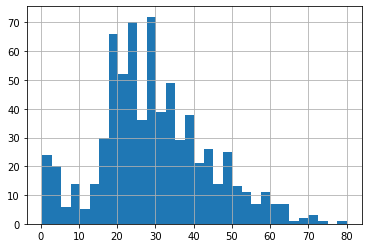

In [7]:
train_set['Age'].hist(bins=32)

In [8]:
# All names in the dataset have format "Surname, Title. Name"
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

In [9]:
titles = sorted(set([x for x in train_set.Name.map(lambda x: get_title(x))]))
print('Different titles found on the dataset:', len(titles))
print(titles)

Different titles found on the dataset: 17
['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']


In [10]:
# Normalize the titles, returning 'Mr', 'Master', 'Miss' or 'Mrs'
def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [11]:
train_set['Title'] = train_set['Name'].map(lambda x: get_title(x))
test_set['Title'] = test_set['Name'].map(lambda x: get_title(x))

In [12]:
train_set['Title']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

In [13]:
train_set['Title'] = train_set.apply(replace_titles, axis=1)
test_set['Title'] = test_set.apply(replace_titles, axis=1)

In [14]:
train_set['Title']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886      Mr
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

<AxesSubplot:ylabel='Title'>

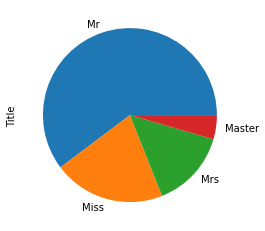

In [15]:
train_set.Title.value_counts().plot(kind='pie')

In [16]:
def data_prep(set):
    set = set.drop(columns=['Name','Ticket', 'Fare', 'Cabin', 'PassengerId'])
    set = set.dropna()
    set['Sex'] = set['Sex'].replace('male', 1)
    set['Sex'] = set['Sex'].replace('female', 0)
    set['Title'] = set['Title'].replace('Mr', 0)
    set['Title'] = set['Title'].replace('Master', 1)
    set['Title'] = set['Title'].replace('Miss', 2)
    set['Title'] = set['Title'].replace('Mrs', 3)
    set['Embarked'] = set['Embarked'].replace('C', 0)
    set['Embarked'] = set['Embarked'].replace('S', 1)
    set['Embarked'] = set['Embarked'].replace('Q', 2)
    set['Age'] = set['Age'].astype(np.int64)
    return set

def data_prep_family_drop(set):
    set = set.drop(columns=['SibSp','SibSp','Title'])
    return set

In [17]:
train_set = data_prep(train_set)
train_set

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title
0,0,3,1,22,1,0,1,0
1,1,1,0,38,1,0,0,3
2,1,3,0,26,0,0,1,2
3,1,1,0,35,1,0,1,3
4,0,3,1,35,0,0,1,0
...,...,...,...,...,...,...,...,...
885,0,3,0,39,0,5,2,3
886,0,2,1,27,0,0,1,0
887,1,1,0,19,0,0,1,2
889,1,1,1,26,0,0,0,0


In [18]:
test_set = data_prep(test_set)
test_set

,Pclass,Sex,Age,SibSp,Parch,Embarked,Title
0,3,1,34,0,0,2,0
1,3,0,47,1,0,1,3
2,2,1,62,0,0,2,0
3,3,1,27,0,0,1,0
4,3,0,22,1,1,1,3
...,...,...,...,...,...,...,...
409,3,0,3,1,1,1,2
411,1,0,37,1,0,2,3
412,3,0,28,0,0,1,2
414,1,0,39,0,0,0,3


In [19]:
train_set_survivors = train_set['Survived']
train_set = train_set.drop(columns=['Survived'])
train_set

,Pclass,Sex,Age,SibSp,Parch,Embarked,Title
0,3,1,22,1,0,1,0
1,1,0,38,1,0,0,3
2,3,0,26,0,0,1,2
3,1,0,35,1,0,1,3
4,3,1,35,0,0,1,0
...,...,...,...,...,...,...,...
885,3,0,39,0,5,2,3
886,2,1,27,0,0,1,0
887,1,0,19,0,0,1,2
889,1,1,26,0,0,0,0


In [20]:
# Big X, low y - convention, Decision Tree
X_train, X_test, y_train, y_test = train_test_split(train_set, train_set_survivors, test_size=0.25, random_state=7)
train_tree = tree.DecisionTreeClassifier(max_depth=tree_depth)
train_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [21]:
train_tree.predict(test_set)

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,

In [22]:
y_pred = train_tree.predict(X_test)
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))

(0.7424242424242424, 0.7205882352941176, 0.7313432835820897, None)


[[93 17]
 [19 49]]


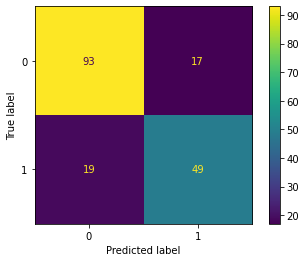

In [23]:
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(train_tree, X_test, y_test)

In [24]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.74      0.72      0.73        68

    accuracy                           0.80       178
   macro avg       0.79      0.78      0.78       178
weighted avg       0.80      0.80      0.80       178



In [25]:
Decision_tree_family = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))  

0.797752808988764


In [26]:
#Random Forest

In [27]:
train_forest = RandomForestClassifier(n_estimators=trees_in_forest, max_depth=tree_depth)
train_forest.fit(X_train, y_train.values.ravel())
train_forest.predict(test_set)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,

In [28]:
y_pred = train_forest.predict(X_test)
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))

(0.8448275862068966, 0.7205882352941176, 0.7777777777777778, None)


[[101   9]
 [ 19  49]]


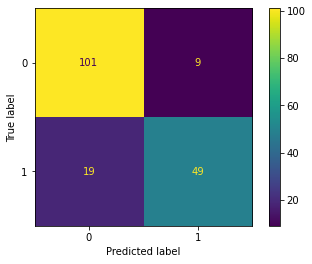

In [29]:
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(train_forest, X_test, y_test)

In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       110
           1       0.84      0.72      0.78        68

    accuracy                           0.84       178
   macro avg       0.84      0.82      0.83       178
weighted avg       0.84      0.84      0.84       178



In [31]:
Random_forest_family = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.8426966292134831


In [32]:
#Test with no family data, Decision Tree

In [33]:
train_set = data_prep_family_drop(train_set)
train_set

,Pclass,Sex,Age,Parch,Embarked
0,3,1,22,0,1
1,1,0,38,0,0
2,3,0,26,0,1
3,1,0,35,0,1
4,3,1,35,0,1
...,...,...,...,...,...
885,3,0,39,5,2
886,2,1,27,0,1
887,1,0,19,0,1
889,1,1,26,0,0


In [34]:
test_set = data_prep_family_drop(test_set)
test_set

,Pclass,Sex,Age,Parch,Embarked
0,3,1,34,0,2
1,3,0,47,0,1
2,2,1,62,0,2
3,3,1,27,0,1
4,3,0,22,1,1
...,...,...,...,...,...
409,3,0,3,1,1
411,1,0,37,0,2
412,3,0,28,0,1
414,1,0,39,0,0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(train_set, train_set_survivors, test_size=0.25, random_state=7)
train_tree = tree.DecisionTreeClassifier(max_depth=tree_depth)
train_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [36]:
train_tree.predict(test_set)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,

In [37]:
y_pred = train_tree.predict(X_test)
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))

(0.7894736842105263, 0.6617647058823529, 0.72, None)


[[98 12]
 [23 45]]


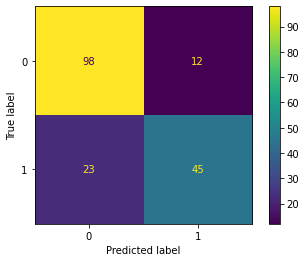

In [38]:
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(train_tree, X_test, y_test)

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.66      0.72        68

    accuracy                           0.80       178
   macro avg       0.80      0.78      0.78       178
weighted avg       0.80      0.80      0.80       178



In [40]:
Decision_tree_no_family = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.8033707865168539


In [41]:
#Test with no family data, Random Forest

In [42]:
train_forest = RandomForestClassifier(n_estimators=trees_in_forest, max_depth=tree_depth)
train_forest.fit(X_train, y_train.values.ravel())
train_forest.predict(test_set)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,

In [43]:
y_pred = train_forest.predict(X_test)
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))

(0.7962962962962963, 0.6323529411764706, 0.7049180327868853, None)


[[99 11]
 [25 43]]


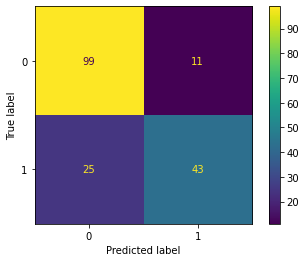

In [44]:
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(train_forest, X_test, y_test)

In [45]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       110
           1       0.80      0.63      0.70        68

    accuracy                           0.80       178
   macro avg       0.80      0.77      0.78       178
weighted avg       0.80      0.80      0.79       178



In [46]:
Random_forest_no_family = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.797752808988764


In [47]:
print('Accuracy of Decision Tree, taking family in account: ' + str(Decision_tree_family))
print('Accuracy of Random Forest, taking family in account: ' + str(Random_forest_family))
print('Accuracy of Decision Tree, not taking family in account: ' + str(Decision_tree_no_family))
print('Accuracy of Decision Tree, not taking family in account: ' + str(Random_forest_no_family))

Accuracy of Decision Tree, taking family in account: 0.797752808988764
Accuracy of Random Forest, taking family in account: 0.8426966292134831
Accuracy of Decision Tree, not taking family in account: 0.8033707865168539
Accuracy of Decision Tree, not taking family in account: 0.797752808988764


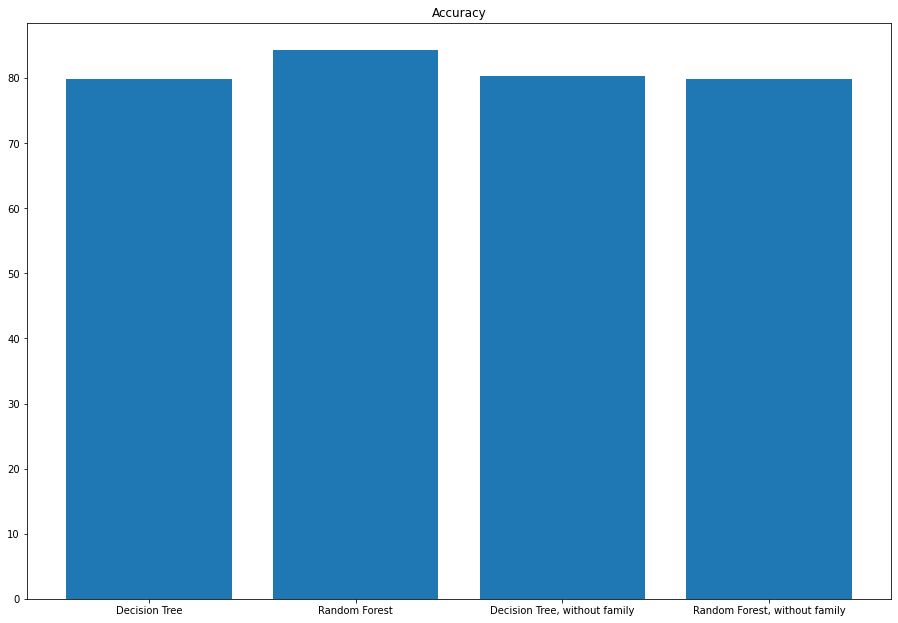

In [48]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
accuracy_labels = ['Decision Tree', 'Random Forest', 'Decision Tree, without family', 'Random Forest, without family']
accuracy_data = [Decision_tree_family*100,Random_forest_family*100,Decision_tree_no_family*100,Random_forest_no_family*100]
ax.bar(accuracy_labels,accuracy_data)
plt.title('Accuracy')
plt.show()

# Analiza i ocena wyników

Największą efektywność wykazał model 'Random Forest' z większą ilością danych. Model jest w stanie przewidzieć w 85%, to czy dany pasażer przeżył rejs Titaniciem. Jest on najskuteczniejszy, ponieważ zawiera w sobie 1000 różnych drzew, które wspólnie, na podstawie średnich wyników podejmują decyzję. Wariant z danymi bez informacji o rodzinie cechuje się mniejszą skutecznością, co sugeruje że jest to ważna kolumna.